# Winning Streaks Comparison Study

### 1. Imports

In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing libraries and switching to the right directory
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os  
from google.colab import drive
from tqdm.notebook import tqdm
sns.set_theme()

# mounting ggdrive 
drive.mount('/content/drive')

# custom data paths - each person should add their own file to the ggdrive 'Data Analytics - Group Final Projects' folder if they want to use ggcolab :D
paths = {'theau': '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data',
         'victor': '/content/drive/MyDrive/Columbia 1st Semester/Sports Analytics/Sports Analytics - Project/Data/',
         'max': '/content/drive/MyDrive/1_FALL 2022/Sports Analytics/Sports Analytics - Project/Data/'
         }

# setting os chdir
runner = input("Who's running the notebook? (type lowercase) ")
os.chdir(paths[runner])
print("Drive mounted for %s!" %runner)

Mounted at /content/drive
Who's running the notebook? (type lowercase) max
Drive mounted for max!


In [3]:
atp_matches = pd.read_csv('atp_matches_scores/merged_atp_matches.csv')
print('Number of matches: %i' % atp_matches.shape[0])

Number of matches: 64833


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
atp_matches.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

## 2. Extracting Maximum Streaks

###  -- Extracting all matches and their respective count

In [5]:
# all distinct atp players
atp_players_list = pd.concat([atp_matches.winner_name, 
                              atp_matches.loser_name],
                             axis = 0
                             ).unique()
len(atp_players_list)

2345

In [6]:
matches_couples = atp_matches[['winner_name', 'loser_name']].copy()

# we compute all the distinct atp matches and the number of times each match occured
distinct_atp_matches = matches_couples.groupby(
    matches_couples.apply(
        lambda x: tuple(sorted(x)), 
        axis=1)
    ).agg(Player_1=("winner_name", "first"), 
          Player_2=("loser_name", "first"), 
          Count=("loser_name", "size")
          ).reset_index(drop=True
                        ).sort_values(by='Count', 
                                      ascending = False)
distinct_atp_matches.head()

,Player_1,Player_2,Count
33075,Rafael Nadal,Novak Djokovic,59
33087,Roger Federer,Novak Djokovic,51
34271,Rafael Nadal,Roger Federer,41
5899,Novak Djokovic,Andy Murray,37
11990,David Ferrer,Rafael Nadal,32


### -- Fixing dataset anomalies and formats

In [7]:
# there is an issue with some tournament names: 
print("Years with 'US Open' as tournament names: ", atp_matches[atp_matches.tourney_name == 'US Open'].tourney_date.unique())
print("Years with 'Us Open' as tournament names: ", atp_matches[atp_matches.tourney_name == 'Us Open'].tourney_date.unique())

# we choose to therefore capitalize all the tournament names
atp_matches.tourney_name = atp_matches.tourney_name.apply(lambda x: x.upper())

Years with 'US Open' as tournament names:  [20010827 20020826 20030825 20040830 20050829 20060828 20070827 20080825
 20090831 20100830 20110829 20120827 20130826 20140825 20150831 20160829
 20170828 20180827 20190826]
Years with 'Us Open' as tournament names:  [20200831 20210830 20220829]


In [8]:
atp_matches[atp_matches.tourney_name == 'US OPEN'].tourney_date.unique()

array([20010827, 20020826, 20030825, 20040830, 20050829, 20060828,
       20070827, 20080825, 20090831, 20100830, 20110829, 20120827,
       20130826, 20140825, 20150831, 20160829, 20170828, 20180827,
       20190826, 20200831, 20210830, 20220829])

In [9]:
"""  Those cells don't need to be run again. """
# # for practicality, we concatenate the inverted df to compute streaks more easily
# duplicated_matches = pd.concat([distinct_atp_matches,
#                                 pd.DataFrame([distinct_atp_matches.Player_2,
#                                               distinct_atp_matches.Player_1,
#                                               distinct_atp_matches.Count]).T.rename(columns = {'Player_2': 'Player_1',
#                                                                                                'Player_1': 'Player_2'})],
#                                axis = 0)

"  Those cells don't need to be run again. "

### -- Computing winning streaks and storing it in our data folder

Calculate streaks: 
https://joshdevlin.com/blog/calculate-streaks-in-pandas/ 

In [10]:
def generate_streak_info(match):
    """
    Parameters
    ----------
    
    match:
        A dataframe containing data about tennis matches.
        Must contain a `winner_name` column with two
        Must be homogenous (contain only shots
        that qualify for the streak type you want
        to calculate (eg all FT for a single
        player) and be pre-sorted by time.

    Returns
    -------

    match_with_streaks:
        The original dataframe with a new column
        `streak_counter` containing integers with 
        counts for each streak.
    """
    
    data = match['winner_name'].to_frame()
    data['start_of_streak'] = data['winner_name'].ne(data['winner_name'].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data['streak_counter'] = data.groupby('streak_id').cumcount() + 1
    match_with_streaks = pd.concat([match, data['streak_counter']], axis=1)
    return match_with_streaks
    
## ~~~ Testing Function ~~~
# nadal_djoko = chronological_matches.sort_values(by = 'tourney_date')[['tourney_date','winner_name']].set_index('tourney_date')
# match = nadal_djoko['winner_name'].to_frame()
# nad_djoko_streaks = generate_streak_info(nadal_djoko)
# nad_djoko_streaks

In [11]:
""" Those cells don't need to be run again. """

# we now want to compute all streaks between all players

# nb_distinct_matches = distinct_atp_matches.shape[0]
# max_streaks_couples = []
# for i in tqdm(range(nb_distinct_matches)):
#   match = distinct_atp_matches.iloc[i]
#   player_1 = match['Player_1']
#   player_2 = match['Player_2']
#   chronological_matches = atp_matches[((atp_matches.winner_name == player_1) & (atp_matches.loser_name == player_2)) |
#                                       ((atp_matches.winner_name == player_2) & (atp_matches.loser_name == player_1)) ] 

#   couple_df = chronological_matches.sort_values(by = 'tourney_date')[['tourney_date','winner_name']].set_index('tourney_date')

#   # calculate streaks
#   couple_streaks_series = generate_streak_info(couple_df)
#   max_streaks_couples.append((couple_streaks_series[couple_streaks_series.winner_name == player_1].max()['streak_counter'],
#                               couple_streaks_series[couple_streaks_series.winner_name == player_2].max()['streak_counter']))

" Those cells don't need to be run again. "

The step above was very long so we store the streaks computation in a csv, accessible for other purposes later:

In [12]:
""" Those cells don't need to be run again. """

# distinct_atp_matches['Max_Streak_Player_1'] = [couple[0] for couple in max_streaks_couples]
# distinct_atp_matches['Max_Streak_Player_2'] = [couple[1] for couple in max_streaks_couples]
# distinct_atp_matches.to_csv('atp_matches_streaks.csv')

" Those cells don't need to be run again. "

In [13]:
# importing streaks dataframe

atp_matches_streaks = pd.read_csv('atp_matches_streaks.csv').iloc[:,1:]
atp_matches_streaks.Max_Streak_Player_1 = atp_matches_streaks.Max_Streak_Player_1.fillna(0)
atp_matches_streaks.Max_Streak_Player_2 = atp_matches_streaks.Max_Streak_Player_2.fillna(0)
atp_matches_streaks.Max_Streak_Player_1 = atp_matches_streaks.Max_Streak_Player_1.astype(int)
atp_matches_streaks.Max_Streak_Player_2 = atp_matches_streaks.Max_Streak_Player_2.astype(int)

atp_matches_streaks.head()

,Player_1,Player_2,Count,Max_Streak_Player_1,Max_Streak_Player_2
0,Rafael Nadal,Novak Djokovic,59,5,7
1,Roger Federer,Novak Djokovic,51,4,5
2,Rafael Nadal,Roger Federer,41,5,6
3,Novak Djokovic,Andy Murray,37,8,3
4,David Ferrer,Rafael Nadal,32,2,9


### -- Custom winning streaks functions for a specific player

In [14]:
def player_distinct_matches(player, distinct_atp_matches):
  # compute all distinct matches for a given player
  return distinct_atp_matches[(distinct_atp_matches.Player_1 == player) | (distinct_atp_matches.Player_2 == player)].copy()
  
player_distinct_matches('Richard Gasquet', atp_matches_streaks).head(10)

,Player_1,Player_2,Count,Max_Streak_Player_1,Max_Streak_Player_2
24,Richard Gasquet,Roger Federer,21,1,11
31,Rafael Nadal,Richard Gasquet,18,18,0
35,Richard Gasquet,Gael Monfils,18,2,3
38,Richard Gasquet,Tomas Berdych,17,2,3
66,Richard Gasquet,Andy Murray,15,2,6
71,Richard Gasquet,Fernando Verdasco,15,4,5
81,Novak Djokovic,Richard Gasquet,14,11,1
99,David Ferrer,Richard Gasquet,13,5,2
160,Mikhail Youzhny,Richard Gasquet,11,2,2
179,Richard Gasquet,Kei Nishikori,11,6,2


In [15]:
# specific example to develop new function

nadal = player_distinct_matches('Rafael Nadal', atp_matches_streaks)

nadal_duplic = pd.concat([nadal,
                          pd.DataFrame([nadal.Player_2,
                                        nadal.Player_1,
                                        nadal.Count,
                                        nadal.Max_Streak_Player_2,
                                        nadal.Max_Streak_Player_1
                                        ]).T.rename(columns = {'Player_2': 'Player_1',
                                                               'Player_1': 'Player_2',
                                                               'Max_Streak_Player_2': 'Max_Streak_Player_1',
                                                               'Max_Streak_Player_1': 'Max_Streak_Player_2'
                                                               })],
                         axis = 0)
nadal_duplic[nadal_duplic.Player_1 == 'Rafael Nadal'].sort_values(by='Max_Streak_Player_1', ascending = False)

,Player_1,Player_2,Count,Max_Streak_Player_1,Max_Streak_Player_2
12,Rafael Nadal,Tomas Berdych,25,18,3
31,Rafael Nadal,Richard Gasquet,18,18,0
25,Rafael Nadal,Fernando Verdasco,20,13,2
16,Rafael Nadal,Stan Wawrinka,22,12,2
262,Rafael Nadal,Paul Henri Mathieu,10,10,0
...,...,...,...,...,...
15869,Rafael Nadal,Olivier Mutis,1,0,1
6570,Rafael Nadal,Dustin Brown,2,0,2
12654,Rafael Nadal,Joachim Johansson,1,0,1
10085,Rafael Nadal,Alex Corretja,2,0,2


In [16]:
# clean function to get all winning and losing streaks of a player against all his opponents during his carreer

def player_max_streaks_info(player, atp_matches_streaks, column_sort = 'Count'):
  """ 
      Parameters
    ----------
    
    player - str:
        Player's name 
    
    atp_matches_streaks - pd.DataFrame:
        dataframe containing all maximum streaks for each player between every existing ATP confrontation

    column_sort (optional) - str:
        column by which the returned dataframe is sorted

    Returns
    -------

        A dataframe with columns: 'Player', 'Opponent', 'Max_Streak_Player' & 'Max_Streak_Opponent'
  
  """
  matches = player_distinct_matches(player, atp_matches_streaks)

  matches_duplic = pd.concat([matches,
                              pd.DataFrame([matches.Player_2,
                                            matches.Player_1,
                                            matches.Count,
                                            matches.Max_Streak_Player_2,
                                            matches.Max_Streak_Player_1
                                            ]).T.rename(columns = {'Player_2': 'Player_1',
                                                                   'Player_1': 'Player_2',
                                                                   'Max_Streak_Player_2': 'Max_Streak_Player_1',
                                                                   'Max_Streak_Player_1': 'Max_Streak_Player_2'
                                                                   })],
                                axis = 0)
  matches_duplic.Max_Streak_Player_1 = matches_duplic.Max_Streak_Player_1.astype(int)
  matches_duplic.Max_Streak_Player_2 = matches_duplic.Max_Streak_Player_2.astype(int)
  return matches_duplic[matches_duplic.Player_1 == player].rename(columns = {'Player_1': 'Player',
                                                                             'Player_2': 'Opponent',
                                                                             'Max_Streak_Player_1': 'Max_Streak_Player',
                                                                             'Max_Streak_Player_2': 'Max_Streak_Opponent'
                                                                             }
                                                                  ).sort_values(by = column_sort, 
                                                                                ascending = False
                                                                                )

## 3. Streaks Analysis

In [17]:
import plotly.express as px

In [18]:
all_streaks = pd.concat([atp_matches_streaks[['Player_1', 'Max_Streak_Player_1']].rename(columns = {'Player_1': 'Player', 'Max_Streak_Player_1': 'Max Streak'}),
                         atp_matches_streaks[['Player_2', 'Max_Streak_Player_2']].rename(columns = {'Player_2': 'Player', 'Max_Streak_Player_2': 'Max Streak'})
                         ],
                        axis = 0 )

all_unique_max_streaks = all_streaks.groupby('Player').max().sort_values(by = 'Max Streak', ascending = False)
all_unique_max_streaks = all_unique_max_streaks[all_unique_max_streaks['Max Streak'] >= 2]
px.histogram(all_unique_max_streaks, x = 'Max Streak', histnorm = 'percent', title = "All ATP Players Max Streaks distribution")

In [19]:
# all ATP Max Streaks since 2000
all_atp_max_streaks = pd.DataFrame(atp_matches_streaks.Max_Streak_Player_1.tolist() + atp_matches_streaks.Max_Streak_Player_2.tolist(),
                                   columns = ['Max Streak'])
all_atp_max_streaks = all_atp_max_streaks[all_atp_max_streaks['Max Streak'] >= 2]
px.histogram(all_atp_max_streaks, x = 'Max Streak', histnorm = 'percent', title = "All ATP Players Max Streaks distribution")

In [21]:
nadal_streaks = player_max_streaks_info('Rafael Nadal', atp_matches_streaks, 'Max_Streak_Player')
nadal_streaks = nadal_streaks.rename(columns = {'Max_Streak_Player': 'Max Streak'})
px.histogram(nadal_streaks[nadal_streaks['Max Streak'] >= 2], x = 'Max Streak', histnorm = 'percent', title = "All Nadal's Max Streaks")

In [24]:
nadal_streaks = player_max_streaks_info('Rafael Nadal', atp_matches_streaks, 'Max_Streak_Player')
# nadal_streaks.to_excel('nadal_streaks.xlsx')
nadal_streaks.head(10)

In [60]:
print('All ATP Players Average Max Winning Streak: %.2f' % all_atp_max_streaks.mean())
print('Nadal Average Max Winning Streak: %.2f' % nadal_streaks['Max_Streak_Player'].mean())

All ATP Players Average Max Winning Streak: 2.62
Nadal Average Max Winning Streak: 2.69


Text(0.5, 1.0, 'Max Losing Streaks from Richard Gasquet')

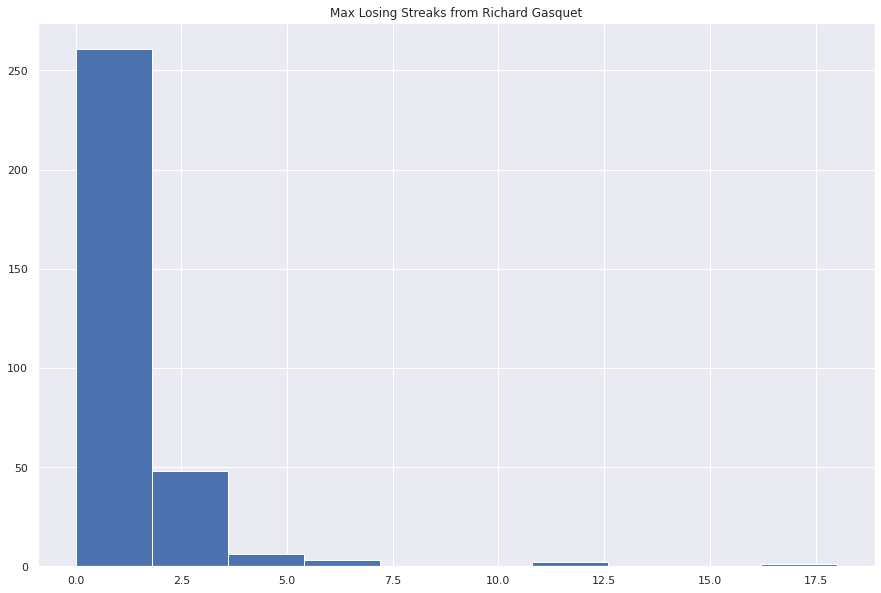

In [26]:
gasquet_streaks = player_max_streaks_info('Richard Gasquet', atp_matches_streaks, 'Max_Streak_Player')
gasquet_streaks.Max_Streak_Opponent.hist(figsize=(15,10))
plt.title('Max Losing Streaks from Richard Gasquet')

## 4. Clustering - Similar players to R. Gasquet

In [39]:
# Importing different types of clustering
harvard_cluster = pd.read_excel('players_clustering_2017.xlsx').set_index('player_name')
righthanded_onehanded_cluster = pd.read_excel('cluster_right_hander_one_handed_backhand.xlsx')
all_court_cluster = harvard_cluster[harvard_cluster.cluster == harvard_cluster.loc['Richard Gasquet']['cluster']]
righthanded_onehanded_cluster = righthanded_onehanded_cluster.set_index('name')
all_court_cluster.head()

,ranking,cluster
player_name,,
Grigor Dimitrov,6,All-Court
Dominic Thiem,16,All-Court
Richard Gasquet,18,All-Court
Philipp Kohlschreiber,22,All-Court
Leonardo Mayer,37,All-Court


In [28]:
harvard_cluster.groupby('cluster').size()

cluster
All-Court              17
Big Server             10
Counter-puncher (l)    16
Counter-puncher (r)    50
dtype: int64

In [29]:
join_cluster = pd.merge(harvard_cluster.reset_index(), 
                        righthanded_onehanded_cluster.reset_index(), 
                        left_on='player_name', 
                        right_on='name')[['name', 'cluster_x']].set_index('name')
# harvard_and_backhand = harvard_and_backhand[harvard_and_backhand.cluster_x == 'All-Court']
join_cluster

,cluster_x
name,
Roger Federer,Big Server
Stan Wawrinka,Big Server
Grigor Dimitrov,All-Court
Dominic Thiem,All-Court
Richard Gasquet,All-Court
Philipp Kohlschreiber,All-Court
Leonardo Mayer,All-Court
Nicolas Almagro,All-Court
Pablo Cuevas,All-Court


In [40]:
nadal_streaks = player_max_streaks_info('Rafael Nadal', 
                                        atp_matches_streaks, 
                                        column_sort = 'Count')
# nadal_streaks = nadal_streaks[nadal_streaks.Count >= 5]
# nadal_streaks[nadal_streaks.Opponent.isin(gasquet_like_players.index.tolist())]

nadal_streaks_style = pd.merge(nadal_streaks, 
                               harvard_cluster.reset_index(),
                               left_on='Opponent',
                               right_on='player_name').drop(['ranking', 'player_name'], axis = 1)
nadal_streaks_style.groupby('cluster').size()

cluster
All-Court              17
Big Server             10
Counter-puncher (l)    15
Counter-puncher (r)    48
dtype: int64

In [41]:
nadal_streaks_style.groupby('cluster').describe()['Max_Streak_Player'][['mean', 'min', '50%', 'max', ]]

,mean,min,50%,max
cluster,,,,
All-Court,5.529412,1.0,5.0,18.0
Big Server,7.700000,5.0,5.5,18.0
Counter-puncher (l),3.800000,1.0,3.0,13.0
Counter-puncher (r),3.604167,0.0,3.0,8.0


In [44]:
print('Cluster 1 - made by Harvard')
print('Gasquet-like players max win streak avg: ', nadal_streaks[nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.mean())
all_court_max_streak_avg = nadal_streaks[nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.mean()
all_court_max_streak_max = nadal_streaks[nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.max()
all_court_max_streak_med = nadal_streaks[nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.describe()['50%']

print(nadal_streaks[nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.shape[0])
print('')
print('Rest of ATP Tour max win streak avg: ', nadal_streaks[~nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.mean())
other_styles_max_streak_avg = nadal_streaks[~nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.mean()
other_styles_max_streak_max = nadal_streaks[~nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.max()
other_styles_max_streak_med = nadal_streaks[~nadal_streaks.Opponent.isin(all_court_cluster.index.tolist())].Max_Streak_Player.describe()['50%']

print("All ATP Tour max Nadal's win streak avg: ", nadal_streaks.Max_Streak_Player.mean())
nadal_max_streak_avg = nadal_streaks.Max_Streak_Player.mean()
nadal_max_streak_max = nadal_streaks.Max_Streak_Player.max()
nadal_max_streak_med = nadal_streaks.Max_Streak_Player.describe()['50%']

print(nadal_streaks.shape[0])
# print(nadal_streaks[~nadal_streaks.Opponent.isin(gasquet_like_players.index.tolist())].Max_Streak_Player.shape)

Cluster 1 - made by Harvard
Gasquet-like players max win streak avg:  5.529411764705882
17

Rest of ATP Tour max win streak avg:  2.531986531986532
All ATP Tour max Nadal's win streak avg:  2.694267515923567
314


In [45]:
df_streaks_results = pd.DataFrame([[round(nadal_max_streak_avg,2), round(all_court_max_streak_avg,2), round(other_styles_max_streak_avg,2)],
                                   [nadal_max_streak_med, all_court_max_streak_med, other_styles_max_streak_med]], 
                                  columns = ['vs. All ATP Players', "vs. Players from Gasquet's Cluster", "vs. Rest of ATP Players"],
                                  index = ["Nadal's Max Streak Average", "Nadal's Max Streak Median"]).T

# df_streaks_results["Nadal's Max Streak Max"] = [nadal_max_streak_max, all_court_max_streak_max, other_styles_max_streak_max]
df_streaks_results

,Nadal's Max Streak Average,Nadal's Max Streak Median
vs. All ATP Players,2.69,2.0
vs. Players from Gasquet's Cluster,5.53,5.0
vs. Rest of ATP Players,2.53,2.0


In [49]:
print('Cluster 2 - right-hander')
print('Gasquet-like players max win streak avg: ', nadal_streaks[nadal_streaks.Opponent.isin(righthanded_onehanded_cluster.index.tolist())].Max_Streak_Player.mean())
print(nadal_streaks[nadal_streaks.Opponent.isin(righthanded_onehanded_cluster.index.tolist())].Max_Streak_Player.shape[0])
print('')
print('Rest of ATP Tour max win streak avg: ', nadal_streaks[~nadal_streaks.Opponent.isin(righthanded_onehanded_cluster.index.tolist())].Max_Streak_Player.mean())
# print(nadal_streaks[~nadal_streaks.Opponent.isin(righthanded_onehanded_cluster.index.tolist())].Max_Streak_Player.shape)
print('All of ATP Tour max win streak avg: ', nadal_streaks.Max_Streak_Player.mean())

Cluster 2 - right-hander
Gasquet-like players max win streak avg:  3.3684210526315788
57

Rest of ATP Tour max win streak avg:  2.544747081712062
All of ATP Tour max win streak avg:  2.694267515923567


In [ ]:
atp_matches = pd.read_csv('atp_matches_scores/merged_atp_matches.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (8,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [56]:
# All Court
all_court_cluster_matches = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == all_court_cluster.index[0])) |
                                        ((atp_matches.winner_name == all_court_cluster.index[0]) & (atp_matches.loser_name == 'Rafael Nadal')) ] 

for player in all_court_cluster.index[1:]:
  df  = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == player)) |
                    ((atp_matches.winner_name == player) & (atp_matches.loser_name == 'Rafael Nadal')) ]  
  all_court_cluster_matches = pd.concat([all_court_cluster_matches, 
                                         df],
                                        axis = 0)


# Right Handed One Handed
righthanded_onehanded_cluster_matches = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == righthanded_onehanded_cluster.index[0])) |
                                                    ((atp_matches.winner_name == righthanded_onehanded_cluster.index[0]) & (atp_matches.loser_name == 'Rafael Nadal')) ] 

for player in righthanded_onehanded_cluster.index[1:]:
  df = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == player)) |
                   ((atp_matches.winner_name == player) & (atp_matches.loser_name == 'Rafael Nadal')) ]
  righthanded_onehanded_cluster_matches = pd.concat([righthanded_onehanded_cluster_matches,
                                                     df],
                                                    axis = 0)


# Join
join_cluster_matches = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == join_cluster.index[0])) |
                                   ((atp_matches.winner_name == join_cluster.index[0]) & (atp_matches.loser_name == 'Rafael Nadal')) ] 

for player in join_cluster.index[1:]:
  df = atp_matches[((atp_matches.winner_name == 'Rafael Nadal') & (atp_matches.loser_name == player)) |
                                          ((atp_matches.winner_name == player) & (atp_matches.loser_name == 'Rafael Nadal')) ]
  join_cluster_matches = pd.concat([join_cluster_matches,
                                    df],
                                   axis = 0)
  
all_nadal_matches = atp_matches[(atp_matches.winner_name == 'Rafael Nadal') | (atp_matches.loser_name == 'Rafael Nadal') ] 

all_court_cluster.cluster += [', Right-Handed, One Handed Backhand']
all_court_cluster.drop('ranking', axis = 1)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster
player_name,
Grigor Dimitrov,"All-Court, Right-Handed, One Handed Backhand, ..."
Dominic Thiem,"All-Court, Right-Handed, One Handed Backhand, ..."
Richard Gasquet,"All-Court, Right-Handed, One Handed Backhand, ..."
Philipp Kohlschreiber,"All-Court, Right-Handed, One Handed Backhand, ..."
Leonardo Mayer,"All-Court, Right-Handed, One Handed Backhand, ..."
Nicolas Almagro,"All-Court, Right-Handed, One Handed Backhand, ..."
Pablo Cuevas,"All-Court, Right-Handed, One Handed Backhand, ..."
Steve Darcis,"All-Court, Right-Handed, One Handed Backhand, ..."
Ivo Karlovic,"All-Court, Right-Handed, One Handed Backhand, ..."


In [59]:
print('All Court')
all_court_pct = round(all_court_cluster_matches[all_court_cluster_matches.winner_name == 'Rafael Nadal'].shape[0] / all_court_cluster_matches.shape[0], 3)*100
print(all_court_pct, '\n')

print('Right Handed One Handed Backhand')
print(round(righthanded_onehanded_cluster_matches[righthanded_onehanded_cluster_matches.winner_name == 'Rafael Nadal'].shape[0] / righthanded_onehanded_cluster_matches.shape[0], 3)*100, '\n')

print('All Nadal matches')
print(round(all_nadal_matches[all_nadal_matches.winner_name == 'Rafael Nadal'].shape[0] / all_nadal_matches.shape[0], 3)*100, '\n')

All Court
91.0 

Right Handed One Handed Backhand
82.69999999999999 

All Nadal matches
83.0 



In [53]:
pd.DataFrame([f'{all_nadal_pct}%' , f'{all_court_pct}%'], 
             index = ['Whole Career', "vs. Players from Gasquet's Cluster"],
             columns = ["Nadal's Win Percentage"])

,Nadal's Win Percentage
Whole Career,83.0%
vs. Players from Gasquet's Cluster,91.0%
